# Sensitive Flights

The police drones, equipped with cameras powerful enough to record faces clearly, have amassed hundreds of hours of video footage of the city’s residents. Their flight paths routinely take them over backyards and residents have spotted the drones above public pools, high schools, hospitals, churches, mosques, immigration law firms and even the city’s Planned Parenthood facility. Privacy advocates argue that the extensive footage captured by the drones makes it difficult to distinguish between flights responding to specific incidents and routine mass surveillance from the sky.

Tim Czaja, 63, has lived off Guava Avenue for 12 years, about a half-mile from police headquarters. Pushing his bicycle downtown one morning, Czaja tells WIRED that he sees police drones on a daily basis—one time even lingering above the nearby public pool. According to flight data, drones have flown through the airspace of the public pool where Czaja saw the drone TK times since 2021. Logs published online from each of these flights indicate that the drones started recording as they lifted off the police department’s roof—inadvertently amassing at least TK hours of footage from the area.

The flight data shows that police drones routinely fly over places that even the Department of Homeland Security considers “protected areas”—places where DHS recognizes that enforcement actions might impact “access to essential services or engagement in essential activities.” Such locations, according to the department, include schools, mental healthcare facilities, and social services. 

About a mile south of the public pool is Chula Vista High School. In the last two years, its students have been exposed to approximately four hours of aerial surveillance, as drones were dispatched to 150 incidents that took them through the airspace of the campus. While many of these dispatches were unrelated to public safety incidents at the school, WIRED’s analysis shows that drones were dispatched to Chula Vista High to assist with welfare checks, missing persons, and fights between students. 


## Load Data

In [47]:
import os
import warnings

import fiona
import geopandas as gpd
import geopy.distance
import gpxpy
import numpy as np
import pandas as pd
from multiprocess.pool import Pool
from tqdm.notebook import tqdm, trange
from loguru import logger
warnings.filterwarnings("ignore")

fiona.drvsupport.supported_drivers["kml"] = "rw"
fiona.drvsupport.supported_drivers["KML"] = "rw"

storage = "/Volumes/easystore/Drones/"

cv_flights = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_cv-flight-manifest.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)
per_second = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_drone-seconds-block-count.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)

flight_details = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"{storage}/gpx-with-census-data.csv", chunksize=100000, dtype=str
            ),
            desc="Loading data",
        )
    ]
)
locations = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/manually-label/sensitive-locations.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

## Load Sensitive Flights

The code to generate this data is at the bottom of this workbook

In [3]:
sensitive_flights = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_sensitive-flights.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)

Loading data: 0it [00:00, ?it/s]

## Analysis
Their flight paths routinely take them over backyards and residents have spotted the drones above public pools, high schools, hospitals, churches, mosques, immigration law firms and even the city’s Planned Parenthood facility. Privacy advocates argue that the extensive footage captured by the drones makes it difficult to distinguish between flights responding to specific incidents and routine mass surveillance from the sky. The flight data shows that police drones routinely fly over places that even the Department of Homeland Security considers “protected areas”—places where DHS recognizes that enforcement actions might impact “access to essential services or engagement in essential activities.” Such locations, according to the department, include schools, mental healthcare facilities, and social services. 


### DHS Defined Areas

- https://www.dhs.gov/sites/default/files/publications/21_1027_opa_guidelines-enforcement-actions-in-near-protected-areas.pdf

In [30]:
counts = []
for sensitive_location in [
    "close_to_Islamic Center of Chula Vista (Masjid Al Momineen) ",
    "close_to_Islamic Center Of Eastlake",
    "close_to_Immigration Services",
    "close_to_Superior Immigration Services ",
    "close_to_MA Immigration Services",
    "close_to_Victory Immigration Firm",
    "close_to_USCIS San Diego ",
    "close_to_Planned Parenthood - Chula Vista Health Center",
    "close_to_Hilltop High",
    "close_to_vista square elementary",
    "close_to_Mueller Charter School",
    "close_to_Bayfront Charter High School",
    "close_to_Chula Vista Learning Community Charter elementary school",
    "close_to_Chula Vista High School",
    "close_to_Harborside Elementary School",
    "close_to_Palomar High School",
    "close_to_Palomar Elementary School",
    "close_to_Moneygram",
]:
    counts.append({"location":sensitive_location,"count": sensitive_flights[sensitive_flights[sensitive_location]=="True"].shape[0]})
sensitive_remapped = pd.DataFrame(counts)

<Axes: xlabel='location'>

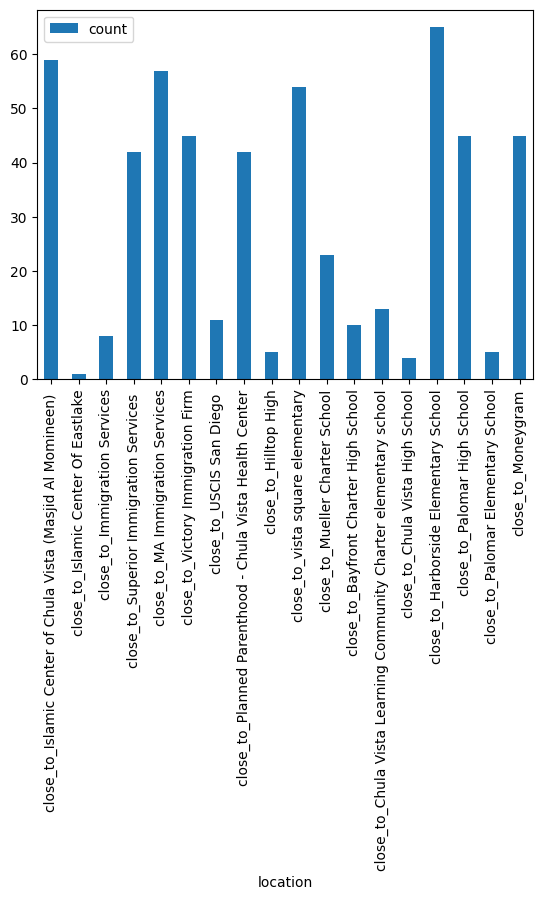

In [29]:
sensitive_remapped.plot.bar(x='location',y='count')

### Public Pool
Tim Czaja, 63, has lived off Guava Avenue for 12 years, about a half-mile from police headquarters. Pushing his bicycle downtown one morning, Czaja tells WIRED that he sees police drones on a daily basis—one time even lingering above the nearby public pool. According to flight data, drones have flown through the airspace of the public pool where Czaja saw the drone TK times since 2021. Logs published online from each of these flights indicate that the drones started recording as they lifted off the police department’s roof—inadvertently amassing at least TK hours of footage from the area.

The pool he is referring to is at the Chula Vista Rec Center (32.638286, -117.082102) - 60730123021012

#### Flights that Passed Through Pools Airspace

These are flights that passed within 20 feet of the pool at any altitude

In [38]:
def calculate_distance(row, target_lat, target_lon):
    origin = (float(row["latitude"]), float(row["longitude"]))
    target = (float(target_lat), float(target_lon))
    distance_in_meters = geopy.distance.geodesic(origin, target).meters
    return distance_in_meters * 3.28084  # Convert meters to feet



def find_pool_flights(index):

    meta = {}
    flight_id = flight_ids.iloc[index]["id"]
    flight = flight_details[flight_details["id"] == flight_id]
    meta["flight_id"] = flight_id

    flight[f"close_to_pool"] = False
    flight[f"distance_to_pool"] = flight.apply(
        calculate_distance, axis=1, args=("32.638286", "-117.082102")
    )

    flight.loc[
        flight[f"distance_to_pool"] <= 20,
        "close_to_pool",
    ] = True

    if flight[flight[f"close_to_pool"] == True].shape[0] > 0:
        meta[f"close_to_pool"] = True
    else:
        meta[f"close_to_pool"] = False

    return meta

# Apply the function to each row in the DataFrame

In [39]:
flight_ids = flight_details[["id"]].drop_duplicates()
with Pool(50) as pool:

    lingering_nd = list(
        tqdm(
            pool.imap(find_pool_flights, range(0, flight_ids.shape[0])),
            total=flight_ids.shape[0],
        )
    )
    lingering_nd = pd.DataFrame(lingering_nd)



  0%|          | 0/8742 [00:00<?, ?it/s]

In [48]:
close_to_pool = lingering_nd[lingering_nd['close_to_pool']==True]
logger.info(f"According to flight data, drones have flown through the airspace of the public pool where Czaja saw the drone {close_to_pool.shape[0]} times since 2021")

2024-05-22 12:53:08.165 | INFO     | __main__:<module>:2 - According to flight data, drones have flown through the airspace of the public pool where Czaja saw the drone 59 times since 2021


#### How long did they spend there in total

In [49]:
flight_blocks = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_drone-seconds-block-count-per-flight.csv", chunksize=100000, dtype=str
            ),
            desc="Loading data",
        )
    ]
)


Loading data: 0it [00:00, ?it/s]

In [64]:
pool_blocks = flight_blocks[flight_blocks['id'].isin(close_to_pool['flight_id'])]

logger.info(f"These flights amassed {pool_blocks[pool_blocks['GEOID20']=='060730123021012']['seconds'].astype(int).sum()/3600} hours of footage")


2024-05-22 13:10:05.480 | INFO     | __main__:<module>:3 - These flights amassed 0.9233333333333333 hours of footage


#### For Fact Check

In [72]:
t = pool_blocks[pool_blocks['GEOID20']=='060730123021012']
t['seconds'] = t['seconds'].astype(int)
t.sort_values('seconds').to_csv('./close-to-pool.csv')

### Chula Vista High 

About a mile south of the public pool is Chula Vista High School. In the last two years, its students have been exposed to approximately four hours of aerial surveillance, as drones were dispatched to 150 incidents that took them through the airspace of the campus. While many of these dispatches were unrelated to public safety incidents at the school, WIRED’s analysis shows that drones were dispatched to Chula Vista High to assist with welfare checks, missing persons, and fights. 


In [80]:
school_flight_blocks = flight_blocks[(flight_blocks['GEOID20']=='060730130003001')]
school_flights_ids = school_flight_blocks['id'].drop_duplicates().values
school_flights = cv_flights[cv_flights['id'].isin(school_flights_ids)]

logger.info(f"Drones were disatched to {school_flights.shape[0]} incidents that took them over the airspace of the school")
logger.info(f"These flights amassed {school_flight_blocks['seconds'].astype(int).sum()/3600} hours of footage")



2024-05-22 13:39:33.940 | INFO     | __main__:<module>:5 - Drones were disatched to 151 incidents that took them over the airspace of the school
2024-05-22 13:39:33.941 | INFO     | __main__:<module>:6 - These flights amassed 3.8405555555555555 hours of footage


## Build Sensitive Flight Data

In [5]:
locations["lat"] = locations["Coordinates"].apply(lambda x: x.split(",")[0].strip())
locations["lon"] = locations["Coordinates"].apply(lambda x: x.split(",")[1].strip())

flight_details = flight_details[flight_details["id"].isin(cv_flights["id"])].copy()

In [31]:
def calculate_distance(row, target_lat, target_lon):
    origin = (float(row["latitude"]), float(row["longitude"]))
    target = (float(target_lat), float(target_lon))
    distance_in_meters = geopy.distance.geodesic(origin, target).meters
    return distance_in_meters * 3.28084  # Convert meters to feet


# Apply the function to each row in the DataFrame

In [32]:
flight_ids = flight_details[["id"]].drop_duplicates()


def find_sensitive_flights(index):

    meta = {}
    flight_id = flight_ids.iloc[index]["id"]
    flight = flight_details[flight_details["id"] == flight_id]
    meta["flight_id"] = flight_id
    for index, t_row in locations.iterrows():
        flight[f"close_to_{t_row['Location']}"] = False
        flight[f"distance_to_{t_row['Location']}"] = flight.apply(
            calculate_distance, axis=1, args=(t_row["lat"], t_row["lon"])
        )

        flight.loc[
            flight[f"distance_to_{t_row['Location']}"] <= 20,
            f"close_to_{t_row['Location']}",
        ] = True

        if flight[flight[f"close_to_{t_row['Location']}"] == True].shape[0] > 0:
            meta[f"close_to_{t_row['Location']}"] = True
        else:
            meta[f"close_to_{t_row['Location']}"] = False

    return meta

In [30]:
find_sensitive_flights(5217)

{'flight_id': '05e887e984fedb291cb1af80fb707f6e',
 'close_to_Islamic Center of Chula Vista (Masjid Al Momineen) ': False,
 'close_to_Islamic Center Of Eastlake': False,
 'close_to_Immigration Services': False,
 'close_to_Superior Immigration Services ': False,
 'close_to_MA Immigration Services': False,
 'close_to_Victory Immigration Firm': False,
 'close_to_USCIS San Diego ': False,
 'close_to_Planned Parenthood - Chula Vista Health Center': False,
 'close_to_Hilltop High': False,
 'close_to_vista square elementary': False,
 'close_to_Mueller Charter School': False,
 'close_to_Bayfront Charter High School': False,
 'close_to_Chula Vista Learning Community Charter elementary school': False,
 'close_to_Chula Vista High School': True,
 'close_to_Harborside Elementary School': False,
 'close_to_Palomar High School': False,
 'close_to_Palomar Elementary School': False,
 'close_to_Moneygram': False}

In [73]:
flight_ids = flight_details[["id"]].drop_duplicates()
with Pool(50) as pool:

    lingering_nd = list(
        tqdm(
            pool.imap(find_sensitive_flights, range(0, flight_ids.shape[0])),
            total=flight_ids.shape[0],
        )
    )
    lingering_nd = pd.DataFrame(lingering_nd)

  0%|          | 0/8742 [00:00<?, ?it/s]

In [14]:
def build_paths(array_of_ids):
    compiled_flights = []
    for flight_id in array_of_ids:

        flight_path = gpd.read_file(
            f"/Volumes/easystore/Drones/flights/kml/{flight_id}.kml", driver="KML"
        )
        flight_path["id"] = flight_id
        compiled_flights.append(flight_path)
    return pd.concat(compiled_flights)

In [15]:
geocodio_flights = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"{storage}/geocodio/all-flights-manifest_geocodio.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)
# a = pd.read_csv('../../data/outputs/outputs_cv-flight-manifest.csv')

Loading data: 0it [00:00, ?it/s]

In [16]:
geocodio_flights[
    (geocodio_flights["address_map"].astype(str).str.contains("1700", case=False))
    & (geocodio_flights["address_map"].astype(str).str.contains("broadway", case=False))
]

,lat_map,lon_map,time,id,date,time_s,address_map,incident_id,type,department,...,Census Block Group,Full FIPS (block),Full FIPS (tract),Metro/Micro Statistical Area Name,Metro/Micro Statistical Area Code,Metro/Micro Statistical Area Type,Combined Statistical Area Name,Combined Statistical Area Code,Metropolitan Division Area Name,Metropolitan Division Area Code
1560,32.5930563443194,-117.074888979111,11:38am,58de5d94143d8527cc132af53a9aa87e,7-23-21,11:38am,1700 Broadway,NaN,Hot Team Assist,cvpd,...,1,060730132051017,06073013205,"San Diego-Chula Vista-Carlsbad, CA",41740,metropolitan,NaN,NaN,NaN,NaN
2836,32.61736464,-117.07162882,1:46pm,ed246d91644ba93bcf07893f9c27a44d,9-14-21,1:46pm,1700 Broadway,CVL77376,Subject Causing Disturbance,cvpd,...,2,060730131022000,06073013102,"San Diego-Chula Vista-Carlsbad, CA",41740,metropolitan,NaN,NaN,NaN,NaN
2837,32.6355209,-117.0731106,1:35pm,a9e795daf6e3f22f45aa3c98cd3f8315,9-14-21,1:35pm,1700 Broadway,CVL77376,Subject Causing Disturbance,cvpd,...,2,060730128002003,06073012800,"San Diego-Chula Vista-Carlsbad, CA",41740,metropolitan,NaN,NaN,NaN,NaN
3139,32.6174123,-117.07167632,8:16am,29b1f6e179d9564bfac69b9a187c7ab6,1-26-22,8:16am,1700 Broadway,CVL7019,DUI,cvpd,...,2,060730131022000,06073013102,"San Diego-Chula Vista-Carlsbad, CA",41740,metropolitan,NaN,NaN,NaN,NaN
6744,32.61742367,-117.07167327,2:44pm,9b0cdb6dbb05c3d58228ec011f4d59f1,9-27-22,2:44pm,1700 Broadway,CV2212713,Stolen vehicle,cvpd,...,2,060730131022000,06073013102,"San Diego-Chula Vista-Carlsbad, CA",41740,metropolitan,NaN,NaN,NaN,NaN
10147,32.61740644,-117.07166125,10:59am,057d62256c1263cc8c35d72250787527,7-13-23,10:59am,1300 Third Av / 1700 Broadway,L059083/ L059088,Disorderly Person/ Impaired Driver,cvpd,...,2,060730131022000,06073013102,"San Diego-Chula Vista-Carlsbad, CA",41740,metropolitan,NaN,NaN,NaN,NaN


In [ ]:
# pool = 060730123021012


060730127003001

In [55]:
lede = per_flight_block_seconds[
    (per_flight_block_seconds["GEOID20"] == "060730132063003")
]
flights = []
for f in lede["id"].drop_duplicates().values:
    flight = per_flight_block_seconds[per_flight_block_seconds["id"] == f]
    flight = flight[flight["GEOID20"] == "060730127003001"]
    if flight.shape[0] > 0:
        flights.append(flight)

,id,GEOID20,seconds,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,NAME20,MTFCC20,UR20,...,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,HOUSING20,POP20,geometry,len
40868,5db1d2295546e6d0d2726877c1c081e2,060730127003001,50,6,73,12700,3001,Block 3001,G5040,U,...,U,S,40518,0,32.6365542,-117.0848466,81,239,"POLYGON ((-117.087049 32.636423, -117.08691 32...",15


In [18]:
pp_paths = build_paths(["29b1f6e179d9564bfac69b9a187c7ab6"])
pp_paths = pd.merge(pp_paths, geocodio_flights, how="left", on="id")

pp_paths[["id", "geometry", "lat_map", "lon_map", "type"]].to_csv(
    "./public_pool.csv", index=False
)
# pp_paths[['geometry','id']].drop_duplicates().to_csv('./low-paths.csv',index=False)

In [43]:
flight_details[flight_details["id"] == "4342f9e237e48c34ddd15271a0ed1dc9"][
    ["sequence", "latitude", "longitude", "altitude"]
].to_csv("./flight.csv", index=False)